In [235]:
#import packages 

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols 
from rasterstats import zonal_stats
import rasterio
import contextily as cx
from rasterio.plot import show
#import osmnx as ox
from affine import Affine
import rioxarray as rx
from multiprocessing import Pool, cpu_count
from shapely.ops import unary_union
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from pathlib import Path
import fiona

#see all columns in tables
pd.set_option('display.max_columns', None)

#set defaults for matplotlib
plt.rcParams.update({'font.family':'Tw Cen MT'})
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({'font.size': 12})



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
%reload_ext autoreload
from src.data.make_dataset import *


In [81]:
mapc_blocks_fp = 'K:\\DataServices\\Projects\\Current_Projects\\Environment\\MS4\\Project\\MS4_Model.gdb'
mapc_blocks = gpd.read_file(mapc_blocks_fp, layer='mapc_2020_blocks')

In [82]:

def heat_score (muni_parcels, heat_index_fp):

    '''
    For each census block  in the municipality, determines the relative heat index score compared to all other block groups. 
    Those in the top 40% of scores are retained as having heat "vulnerability". 
    Parcels within those block groups can then be prioritized higher.

    Inputs: Muni boundary (gdf), heat index raster (geotiff)

    '''
    from rasterstats import zonal_stats
    #from src.data.make_dataset import mapc_blocks

    

    with rasterio.open(heat_index_fp) as raster:
        transform = raster.transform
        lst = raster.read(1).astype('float64')

    #read in census blocks, clip to muni and eliminate sliver blocks that remain
    mapc_blocks['og_area'] = mapc_blocks['geometry'].area
    muni_blocks = mapc_blocks.clip(muni_parcels)
    muni_blocks['pct_bg'] = ((muni_blocks['geometry'].area) / (muni_blocks['og_area'])) * 100

    #only keep block groups where 5% or more of the bg remains. Reset index for zonal stats
    muni_blocks = muni_blocks.loc[muni_blocks['pct_bg'] > 5].reset_index()

    #run zonal stats on heat index - what is the mean lst index score across census block?
    lst_stats = pd.DataFrame(zonal_stats(muni_blocks, 
                                        lst, 
                                        affine=transform, 
                                        stats='mean'))

    #join back to blocks, rename field
    muni_blocks_heat = muni_blocks[['geoid20', 'geometry']].join(lst_stats)
    muni_blocks_heat = muni_blocks_heat.rename(columns={'mean':'lst_mean'})

    #rank each block based on relative lst index score
    muni_blocks_heat['rnk_heat'] = muni_blocks_heat['lst_mean'].rank(method='min', pct=True)
    muni_blocks_heat.head()

    #create a categorical ranking for where each block lands relative to one another
    heat_rule = [
                    (muni_blocks_heat['rnk_heat'] > 0.80),
                    (muni_blocks_heat['rnk_heat'] <= 0.80) & (muni_blocks_heat['rnk_heat'] > 0.60),
                    (muni_blocks_heat['rnk_heat'] <= 0.60) & (muni_blocks_heat['rnk_heat'] > 0.40),
                    (muni_blocks_heat['rnk_heat'] <= 0.40) & (muni_blocks_heat['rnk_heat'] > 0.20),
                    (muni_blocks_heat['rnk_heat'] <= 0.20) & (muni_blocks_heat['rnk_heat'] > 0)
            ]

    choices = ['Very high heat inde', 'Moderately high heat index', 'Moderate heat index', 'Moderately low heat index', 'Very low heat index']

    muni_blocks_heat['heat_cmp'] = np.select(heat_rule, choices, default=np.nan)
    muni_parcels = muni_parcels.sjoin(muni_blocks_heat, how='left').groupby(by='parloc_id').agg('first').reset_index()

    #only keep blocks with the highest relative heat index score
    #muni_blocks_heat_vln = muni_blocks_heat.loc[muni_blocks_heat['rnk_heat'] >= 0.4]

    return(muni_parcels)

In [254]:
#heat_fp = 'K:\\DataServices\\Projects\\Current_Projects\\Climate_Change\\MVP_MMC_Heat_MVP\\00 Task 2 Deliverables\\2.1 Attachments\\00 Uploaded to Sharepoint\\Shapefile_LSTIndex\\LSTindex.tif'

def muni_process(muni, file_path):
    muni_parcels_gdf=gpd.read_file(file_path)
    muni_gdf = muni_parcels_gdf.loc[muni_parcels_gdf['UseDesc'] != 'ROW segment']
    
    land_use_lookup_fp = r"K:\DataServices\Projects\Current_Projects\Climate_Change\MVP_MMC_CoolRoofs_MVP\Data\lookup_tables\land_use_lookup.csv"
    real_estate_lookup_fp = r"K:\DataServices\Projects\Current_Projects\Climate_Change\MVP_MMC_CoolRoofs_MVP\Data\lookup_tables\real_estate_type_lookup.csv"
    real_estate_lookup_codes_fp = r"K:\DataServices\Projects\Current_Projects\Climate_Change\MVP_MMC_CoolRoofs_MVP\Data\lookup_tables\real_estate_lookup.csv"
    land_use_lookup = pd.read_csv(land_use_lookup_fp)
    real_estate_lookup = pd.read_csv(real_estate_lookup_fp)
    real_estate_lookup_code = pd.read_csv(real_estate_lookup_codes_fp)
    
    land_use_lookup['USE_CODE'] = land_use_lookup['USE_CODE'].apply(lambda x: '{0:0>3}'.format(x))
    real_estate_lookup['use_code_3dg'] = real_estate_lookup['use_code_3dg'].str.replace('"', '') 

    muni_gdf = muni_gdf.merge(land_use_lookup, left_on='UseDesc', right_on='USE_DESC', how='left').drop_duplicates()
    muni_gdf = muni_gdf.merge(real_estate_lookup, left_on='USE_CODE', right_on='use_code_3dg', how='left')
    muni_gdf = muni_gdf.merge(real_estate_lookup_code, on='real_estate_type', how='left')
    heat_bnry_rule = [muni_gdf['rnk_heat'] >= 0.8, muni_gdf['rnk_heat'] < 0.8]
    choices = ['in high heat area', 'not in high heat area']
    muni_gdf['heat_mmc'] = np.select(heat_bnry_rule, choices, default=np.nan)
        
    muni_structures = gpd.read_file(building_structures_gdb, layer=building_structures_layer, mask=muni_gdf)
    muni_structures_join_parcels = muni_structures.sjoin(muni_gdf, how='left').groupby(by='STRUCT_ID').agg('first').reset_index()
    
    heat_xtab = pd.crosstab(muni_structures_join_parcels['description'], muni_structures_join_parcels['heat_mmc'], normalize='columns', margins=True, margins_name='All buildings in muni')[['in high heat area', 'All buildings in muni']]
    xtab_plot = heat_xtab.plot.barh(color=['orangered', 'lightgray'])
    plt.title('Property distribution in ' + muni, size=16)
    plt.xlabel('Proportion of buildings', size=14)
    plt.ylabel('Real estate typology',size=14)
    labels = [textwrap.fill(label.get_text(), 50) for label in xtab_plot.get_yticklabels()]
    xtab_plot.set_yticklabels(labels)
    
    # Annotate every single Bar with its value, based on it's width 
    for bars in xtab_plot.containers:
        xtab_plot.bar_label(bars, padding=3, fmt='%.2f', size=10)

    chart_fp = "K:\\DataServices\\Projects\\Current_Projects\\Climate_Change\\MVP_MMC_CoolRoofs_MVP\Charts"          
    plt.savefig(chart_fp + '\\prop_dist_' + muni + '.jpg', bbox_inches='tight')


    
    muni_structures_public_heat_ej = muni_structures_join_parcels.loc[(muni_structures_join_parcels['pblc'] == 1) &
                                                                (muni_structures_join_parcels['rnk_heat'] >= 0.8)&
                                                                (muni_structures_join_parcels['ej'] == 1)]
    count_structures = len((muni_structures_public_heat_ej))


    data = {'muni': [muni],
            'count_ej_public_highheat': [count_structures],
            }

    df = pd.DataFrame(data)

    structures_high_heat = muni_structures_join_parcels.loc[muni_structures_join_parcels['rnk_heat'] >= 0.8]
    #structure_uses_value_counts = structures_high_heat['UseDesc'].value_counts().rename_axis('unique_values').reset_index(name='counts')
    structure_uses_value_counts = structures_high_heat['c'].value_counts().rename_axis('unique_values').reset_index(name='counts')

    structure_uses_value_counts['pct_of_parcels'] = structure_uses_value_counts['counts'] / len(structures_high_heat)

    df['1_use'] = structure_uses_value_counts['unique_values'][0]
    df['1_count'] = structure_uses_value_counts['counts'][0]
    df['1_pct'] = structure_uses_value_counts['pct_of_parcels'][0]

    df['2_use'] = structure_uses_value_counts['unique_values'][1]
    df['2_count'] = structure_uses_value_counts['counts'][1]
    df['2_pct'] = structure_uses_value_counts['pct_of_parcels'][1]

    df['3_use'] = structure_uses_value_counts['unique_values'][2]
    df['3_count'] = structure_uses_value_counts['counts'][2]
    df['3_pct'] = structure_uses_value_counts['pct_of_parcels'][2]

    df['4_use'] = structure_uses_value_counts['unique_values'][3]
    df['4_count'] = structure_uses_value_counts['counts'][3]
    df['4_pct'] = structure_uses_value_counts['pct_of_parcels'][3]

    df['5_use'] = structure_uses_value_counts['unique_values'][4]
    df['5_count'] = structure_uses_value_counts['counts'][4]
    df['5_pct'] = structure_uses_value_counts['pct_of_parcels'][4]

    structure_owner_value_counts = structures_high_heat['par_typ'].value_counts().rename_axis('unique_values').reset_index(name='counts')
    structure_owner_value_counts['par_typ'] = structure_owner_value_counts['counts'] / len(structures_high_heat)

    df['private_ownership_pct'] = structure_owner_value_counts['par_typ'][0]
    df['public_ownership_pct'] = structure_owner_value_counts['par_typ'][1]


    return(df)

In [200]:
file_path = r"K:\DataServices\Projects\Current_Projects\Environment\MS4\Data\Spatial\Output\Parcels\Arlington\Arlington_MS4_GI_parcels.shp"
muni_parcels_gdf=gpd.read_file(file_path)
muni_gdf = muni_parcels_gdf.loc[muni_parcels_gdf['UseDesc'] != 'ROW segment']

land_use_lookup_fp = r"K:\DataServices\Projects\Current_Projects\Climate_Change\MVP_MMC_CoolRoofs_MVP\Data\lookup_tables\land_use_lookup.csv"
real_estate_lookup_fp = r"K:\DataServices\Projects\Current_Projects\Climate_Change\MVP_MMC_CoolRoofs_MVP\Data\lookup_tables\real_estate_type_lookup.csv"
real_estate_lookup_codes_fp = r"K:\DataServices\Projects\Current_Projects\Climate_Change\MVP_MMC_CoolRoofs_MVP\Data\lookup_tables\real_estate_lookup.csv"
land_use_lookup = pd.read_csv(land_use_lookup_fp)
real_estate_lookup = pd.read_csv(real_estate_lookup_fp)
real_estate_lookup_code = pd.read_csv(real_estate_lookup_codes_fp)

land_use_lookup['USE_CODE'] = land_use_lookup['USE_CODE'].apply(lambda x: '{0:0>3}'.format(x))
real_estate_lookup['use_code_3dg'] = real_estate_lookup['use_code_3dg'].str.replace('"', '') 

muni_gdf = muni_gdf.merge(land_use_lookup, left_on='UseDesc', right_on='USE_DESC', how='left').drop_duplicates()
muni_gdf = muni_gdf.merge(real_estate_lookup, left_on='USE_CODE', right_on='use_code_3dg', how='left')
muni_gdf = muni_gdf.merge(real_estate_lookup_code, on='real_estate_type', how='left')

heat_bnry_rule = [
    muni_gdf['rnk_heat'] >= 0.8,
    muni_gdf['rnk_heat'] < 0.8
]

choices = ['in high heat area', 'not in high heat area']

muni_gdf['heat_mmc'] = np.select(heat_bnry_rule, choices, default=np.nan)


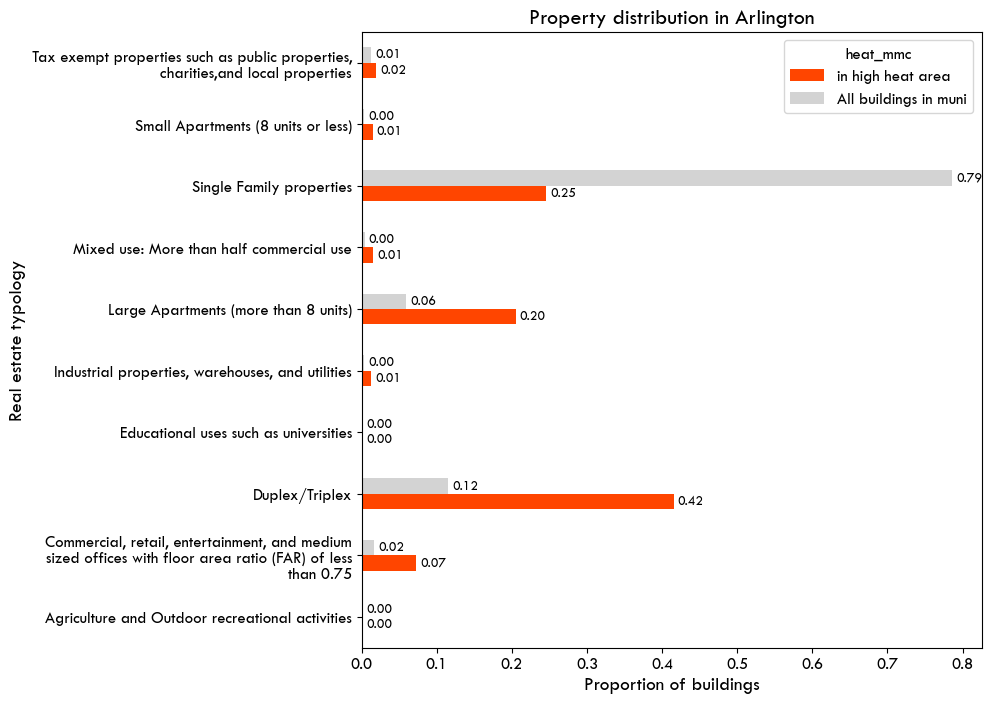

In [252]:
from textwrap import wrap

muni = 'Arlington'
heat_xtab = pd.crosstab(muni_gdf['description'], muni_gdf['heat_mmc'], normalize='columns', margins=True, margins_name='All buildings in muni')[['in high heat area', 'All buildings in muni']]
heat_xtab

xtab_plot = heat_xtab.plot.barh(color=['orangered', 'lightgray'])
plt.title('Property distribution in ' + muni, size=16)
plt.xlabel('Proportion of buildings', size=14)
plt.ylabel('Real estate typology',size=14)
labels = [textwrap.fill(label.get_text(), 50) for label in xtab_plot.get_yticklabels()]
xtab_plot.set_yticklabels(labels)

# Annotate every single Bar with its value, based on it's width           
for bars in xtab_plot.containers:
    xtab_plot.bar_label(bars, padding=3, fmt='%.2f', size=10)

chart_fp = "K:\\DataServices\\Projects\\Current_Projects\\Climate_Change\\MVP_MMC_CoolRoofs_MVP\Charts"
plt.savefig(chart_fp + '\\prop_dist_' + muni + '.jpg', bbox_inches='tight')


KeyError: 'c'

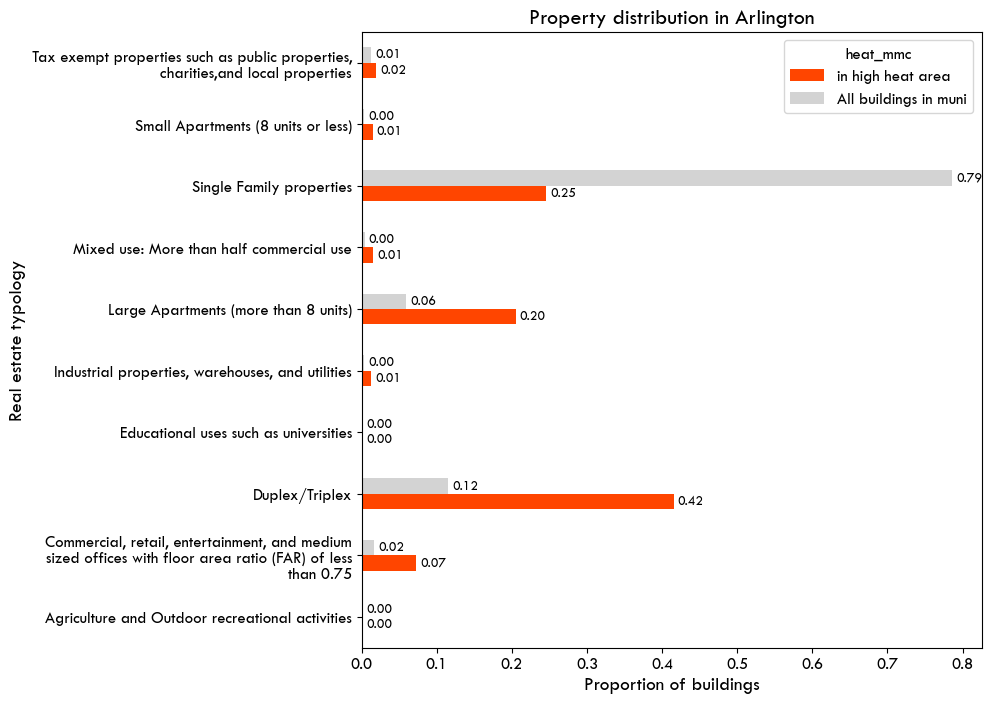

In [255]:
muni_process('Arlington', r"K:\DataServices\Projects\Current_Projects\Environment\MS4\Data\Spatial\Output\Parcels\Arlington\Arlington_MS4_GI_parcels.shp")

In [192]:
mmc_data_frame = pd.DataFrame(columns=['muni', 'count_ej_public_highheat', '1_use', '1_count', '1_pct',
                                    '2_use', '2_count', '2_pct', '3_use', '3_count', '3_pct', '4_use',
                                    '4_count', '4_pct', '5_use', '5_count', '5_pct',
                                    'private_ownership_pct', 'public_ownership_pct'])


muni_shp_list = []
for root, folder, files in os.walk(ms4_parcels_folder):
    for file in files:
        for muni in mmc_munis:
            if muni in file:
                if file.endswith('.shp'):
                    fullname = os.path.join(root, file)
                    muni_df = muni_process(muni, fullname)
                    mmc_data_frame = mmc_data_frame.append(muni_df, ignore_index=True)

#mmc_gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in muni_shp_list], 
#                        ignore_index=True), crs=gpd.read_file(muni_shp_list[0]).crs)

intermediate_fp = r"K:\DataServices\Projects\Current_Projects\Climate_Change\MVP_MMC_CoolRoofs_MVP\Data\Intermediate"
mmc_data_frame.to_csv(intermediate_fp + '\\MMC_muni_summaries_realestate_codes.csv')

In [194]:
mmc_data_frame.head(20)

,muni,count_ej_public_highheat,1_use,1_count,1_pct,2_use,2_count,2_pct,3_use,3_count,3_pct,4_use,4_count,4_pct,5_use,5_count,5_pct,private_ownership_pct,public_ownership_pct
0,Arlington,51,Duplex/Triplex,1585,0.508339,Large Apartments (more than 8 units),787,0.252405,Single Family properties,423,0.135664,"Commercial, retail, entertainment, and medium ...",142,0.045542,Small Apartments (8 units or less),46,0.014753,0.980757,0.019243
1,Boston,532,Duplex/Triplex,6419,0.344792,Tax exempt properties such as public propertie...,4380,0.235269,Single Family properties,2922,0.156953,Large Apartments (more than 8 units),986,0.052962,Small Apartments (8 units or less),892,0.047913,0.959875,0.040125
2,Braintree,71,Single Family properties,1011,0.582709,Duplex/Triplex,238,0.137176,"Commercial, retail, entertainment, and medium ...",181,0.104323,"Industrial properties, warehouses, and utilities",92,0.053026,Large Apartments (more than 8 units),71,0.040922,0.953314,0.046686
3,Brookline,46,Large Apartments (more than 8 units),378,0.337802,Duplex/Triplex,239,0.213584,Single Family properties,217,0.193923,"Commercial, retail, entertainment, and medium ...",116,0.103664,Small Apartments (8 units or less),46,0.041108,0.958892,0.041108
4,Cambridge,58,Duplex/Triplex,734,0.349524,Single Family properties,312,0.148571,Small Apartments (8 units or less),180,0.085714,"Commercial, retail, entertainment, and medium ...",165,0.078571,Large Apartments (more than 8 units),121,0.057619,0.972381,0.027619
5,Chelsea,10,Duplex/Triplex,236,0.393333,Single Family properties,75,0.125000,"Commercial, retail, entertainment, and medium ...",68,0.113333,"Industrial properties, warehouses, and utilities",39,0.065000,Small Apartments (8 units or less),17,0.028333,0.983333,0.016667
6,Everett,57,Duplex/Triplex,620,0.467572,Single Family properties,299,0.225490,"Commercial, retail, entertainment, and medium ...",120,0.090498,"Industrial properties, warehouses, and utilities",100,0.075415,Small Apartments (8 units or less),66,0.049774,0.955505,0.044495
7,Malden,32,Duplex/Triplex,761,0.427768,Single Family properties,507,0.284992,"Commercial, retail, entertainment, and medium ...",157,0.088252,Large Apartments (more than 8 units),113,0.063519,"Industrial properties, warehouses, and utilities",110,0.061832,0.982012,0.017988
8,Medford,60,Duplex/Triplex,1925,0.561224,Single Family properties,831,0.242274,"Commercial, retail, entertainment, and medium ...",170,0.049563,"Industrial properties, warehouses, and utilities",84,0.024490,Tax exempt properties such as public propertie...,52,0.015160,0.982507,0.017493
9,Melrose,16,Single Family properties,672,0.471248,Duplex/Triplex,370,0.259467,Large Apartments (more than 8 units),145,0.101683,"Commercial, retail, entertainment, and medium ...",103,0.072230,Small Apartments (8 units or less),36,0.025245,0.972651,0.027349
